# 1 Graphs

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pygsp import graphs

## 1.1 Creation

Most likely, the first thing you would like to do is to create a graph. In this toolbox, a graph is encoded as a weighted adjacency matrix. That is because it’s the most efficient representation to deal with when using spectral methods. As such, you can construct a graph from any adjacency matrix as follows.

In [2]:
W = np.random.uniform(size=(30, 30))  # Full graph.
W[W < 0.93] = 0  # Sparse graph.
W = W + W.T  # Symmetric graph.
np.fill_diagonal(W, 0)  # No self-loops.

G = graphs.Graph(W)

print(f'{G.N} nodes, {G.Ne} edges')

30 nodes, 50 edges


Graphs can also be created from network models, such as the well-known [Erdős–Rényi](https://en.wikipedia.org/wiki/Erd%C5%91s%E2%80%93R%C3%A9nyi_model).

In [3]:
G = graphs.ErdosRenyi(50, p=0.2)
print(f'{G.N} nodes, {G.Ne} edges')

50 nodes, 238 edges


In [4]:
G = graphs.Community(N=100, Nc=5)
print(f'{G.N} nodes, {G.Ne} edges')

2018-09-14 03:28:18,675:[INFO](pygsp.graphs.community.__init__): Constructed using eps-NN with eps = 2.23606797749979


100 nodes, 330 edges


Finally, graphs can also be constructed from a set of points in $\mathbb{R}^d$.

Let $\mathbf{X}$ be a data matrix $\mathbf{X} = [\mathbf{x}_1, \ldots, \mathbf{x}_N]^\intercal \in \mathbb{R}^{N \times d}$, where each $\mathbf{x} \in \mathbb{R}^d$ is a sample for which we have $d$ features.

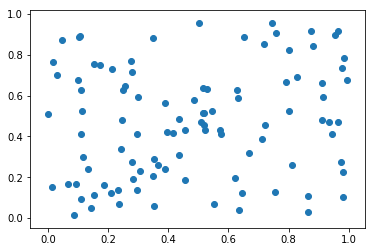

In [5]:
n_points = 100
dimensionality = 2
points = np.random.uniform(size=(n_points, dimensionality))
plt.scatter(points[:, 0], points[:, 1]);

We may separate the task of building a graph from a set of points in two sub-tasks:
* **Finding the structure (the existing edges)**. Two classical approaches are:
    * connecting a point to its $k$-nearest neighbors (kNN graph),
    * connecting a point to all points closer than $\epsilon$ (in some measure); 
* **Associate a weight to each existing edge** (optional). In general, we want that the closer a pair of points, the larger the weight on the associated edge. A classical option is the Gaussian kernel:
$$\mathbf{W}[i,j] = \exp(-\frac{||\mathbf{x}_i - \mathbf{x}_j||^2_2 }{ \sigma^2})$$ 

In [6]:
sigma=0.1

In [7]:
G = graphs.NNGraph(points, NNtype='knn', k=2, sigma = sigma**2, rescale=False, symmetrize_type='maximum')
print(f'{G.N} nodes, {G.Ne} edges')

100 nodes, 127 edges


In [8]:
G = graphs.NNGraph(points, NNtype='radius', epsilon=0.1, sigma = sigma**2, rescale=False, symmetrize_type='maximum')
print(f'{G.N} nodes, {G.Ne} edges')

100 nodes, 159 edges


## 1.2 Properties

The [pygsp.graphs.Graph](https://pygsp.readthedocs.io/en/stable/reference/graphs.html) class we just instantiated is the base class
for all graph objects, which offers many methods and attributes.

Given, a graph object, we can access and test some properties.

As we've used before, there is the number of nodes and edges.

In [9]:
print(G.N)
print(G.Ne)

100
159


We can also test if the graph is connected or directed.

In [10]:
print(G.is_connected())
print(G.is_directed())

False
False


We can retrieve the weighted adjacency matrix, which is stored in a sparse format.

In [11]:
G.W

<100x100 sparse matrix of type '<class 'numpy.float64'>'
	with 318 stored elements in LInked List format>

And visualize its sparsity pattern:

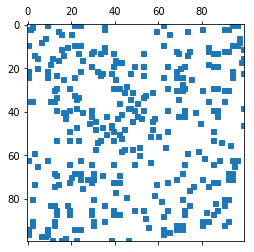

In [12]:
plt.spy(G.W, markersize=5);
#plt.imshow(G.W.toarray());

We can access the [graph Laplacian](https://en.wikipedia.org/wiki/Laplacian_matrix), defined as
$$ L = D - W $$
for the combinatorial Laplacian, and
$$ L = I - D^{-1/2} W  D^{-1/2} $$
for the normalized Laplacian, where $D$ is the diagonal degree matrix.

In [13]:
G.compute_laplacian('combinatorial') 
#or G.compute_laplacian('normalized') ##the normalized Lap may yield an error if there exist a node with degree 0!
G.L

<100x100 sparse matrix of type '<class 'numpy.float64'>'
	with 410 stored elements in Compressed Sparse Column format>

We can also get another representation of a graph: the edge list.
Note that if the graph is not directed the number of edges is half the number of non-zeros in the adjacency matrix.

In [14]:
v_in, v_out, weights = G.get_edge_list()
print(v_in.shape, v_out.shape, weights.shape)

(159,) (159,) (159,)


## 1.3 Visualization

To be able to plot a graph, we need to embed its nodes in a 2D or 3D space. The process to find coordinates for each nodes is called [layout](https://en.wikipedia.org/wiki/Graph_drawing). Most included graph models define these. If that's not the case, or if you create the graph from an adjacency matrix, [`pygsp.graphs.Graph.set_coordinates()`](https://pygsp.readthedocs.io/en/stable/reference/graphs.html#pygsp.graphs.Graph.set_coordinates) can be used to set it.

In our previous example, the nodes had a natural 2D embedding. It is thus logical to plot it using the 2D coordinates of each point in the point cloud:

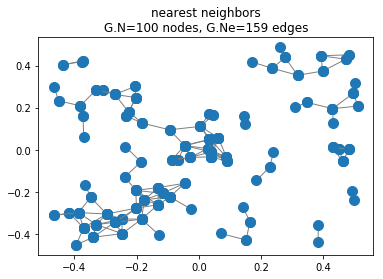

In [15]:
G.plot()

Nevertheless, the **same** graph could be drawn in many different ways. Below are two different options:

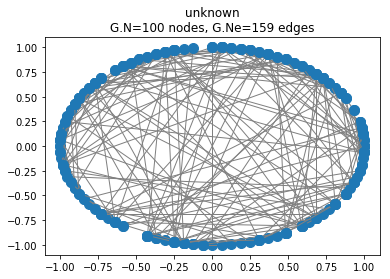

In [16]:
G2 = graphs.Graph(G.W)
G2.set_coordinates(kind='ring2D') #here with a spring based algorithm
G2.plot()

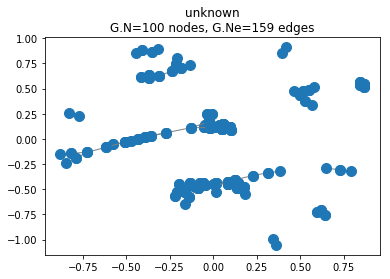

In [17]:
G2 = graphs.Graph(G.W)
G2.set_coordinates(kind='spring') #here with a spring based algorithm
G2.plot()

For a more interactive visualization, you can use [Gephi](https://gephi.org/) or [Cytoscape](http://www.cytoscape.org/).

## 1.4 Exercise: The Barabasi-Albert model

1. Create a graph from the [Barabási–Albert](https://en.wikipedia.org/wiki/Barab%C3%A1si%E2%80%93Albert_model) model.
2. Compute and plot its degree distributions.
3. Plot the graph in 2D with a force-directed layout.

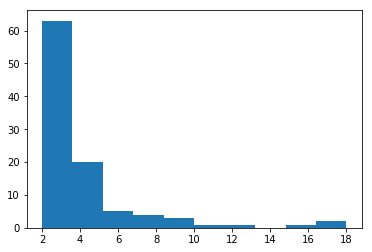

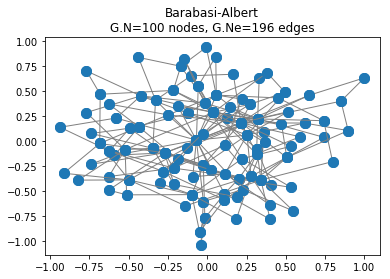

In [18]:
# Your code here.
G = graphs.BarabasiAlbert(100, m0=2, m=2)
plt.hist(G.dw)
G.set_coordinates()
G.plot()

## 1.5 Exercise: connectedness phase transition in Erdös-Rényi graphs

Erdös Rényi graphs have a "connectedness phase transition" at $p=\frac{\log{N}}{N}$. That is, as $N\rightarrow\infty$:
* if $p<\frac{\log{N}}{N}$ the graph is a.s. disconnected
* if $p>\frac{\log{N}}{N}$ the graph is a.s. connected

Illustrate this phase transition computationally

In [19]:
# Your code here.